In [1]:
%pip install tensorflow pandas numpy scikit-learn matplotlib seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached markdown_it_py-4.0.0-py3-none-any.whl.metadata (7.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 1.7 MB/s eta 0:03:19
   ---------------------------------------- 0.8/332.0 MB 1.6 MB/s eta 0:03:27
   ---------------------------------------- 1.3/332.0 MB 1.7 MB/s eta 0:03:20
   ---------------------------------------- 1.6/332.0 MB 1.7 MB/s eta 0:03:15
   ---------------------------------------- 1.8/332.0 MB 1.7 MB/s eta 0:03:19
   ---------------------------------------- 2.4/332.0 MB 1.7 MB/s eta 0:03:16
   ---------------------------------------- 2.6/332.0 MB 1.7 MB/s eta 0:03:13
   ---------------------------------------- 3.1/332


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, 
    SimpleRNN,    
    Dense, 
    SpatialDropout1D, 
    Bidirectional, 
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import kagglehub

print(f"Versión de TensorFlow: {tf.__version__}")

Versión de TensorFlow: 2.20.0


In [4]:
# --- 1. Preparación de Datos con Conjunto de Validación ---

SEMILLA_MAESTRA = 42

def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(SEMILLA_MAESTRA)

def prepare_data_with_val(subset_lang='en', max_vocab=20000, max_len=150):
    print("\n Cargando y procesando datos con Validación...")
    
    # Carga
    path = kagglehub.dataset_download("mexwell/amazon-reviews-multi")
    df = pd.read_csv(path + "/train.csv")
    
    # Filtrado por idioma
    df = df[df['language'] == subset_lang]
    print(f"   -> Total reseñas ('{subset_lang}'): {len(df)}")
    
    # Limpieza y etiquetas
    texts = (df["review_title"].fillna("") + " " + df["review_body"].fillna("")).values
    labels = df["stars"].values - 1 
    
    # --- Tokenización ---
    print("   -> Tokenizando...")
    tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(sequences, maxlen=max_len, padding='post')
    y = np.array(labels)
    
    # División en Train, Val y Test
    # --- SPLIT EXACTO 80 / 10 / 10 ---
    
    # PASO 1: Sacamos el 10% para TEST. Queda el 90% (Temp).
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.10, random_state=SEMILLA_MAESTRA, stratify=y
    )
    
    # PASO 2: Sacamos el 10% del total original para VALIDACIÓN.
    # Queda el 80% para TRAIN.
    val_split = 1/9
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_split, random_state=SEMILLA_MAESTRA, stratify=y_temp
    )
    
    print(f"   -> ✅ Train shape: {X_train.shape}")
    print(f"   -> ✅ Val shape:   {X_val.shape}")
    print(f"   -> ✅ Test shape:  {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, len(tokenizer.word_index) + 1

# Ejecutar la preparación
X_train, X_val, X_test, y_train, y_val, y_test, vocab_size = prepare_data_with_val()
EMBEDDING_DIM = 100


 Cargando y procesando datos con Validación...
   -> Total reseñas ('en'): 200000
   -> Tokenizando...
   -> ✅ Train shape: (160000, 150)
   -> ✅ Val shape:   (20000, 150)
   -> ✅ Test shape:  (20000, 150)


In [5]:
# --- 3. DEFINICIÓN DE LOS 3 MODELOS (SIMPLERNN) ---

def get_optimizer():
    # Usamos clipnorm para evitar que la SimpleRNN explote (NaN)
    return tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

def build_baseline(vocab, dim, length):
    model = Sequential([
        Embedding(vocab, dim, input_length=length),
        SpatialDropout1D(0.2), # Ayuda a evitar overfitting
        SimpleRNN(64, activation='tanh'),
        Dense(5, activation='softmax')
    ], name="1_Baseline_Simple")
    model.compile(loss='sparse_categorical_crossentropy', optimizer=get_optimizer(), metrics=['accuracy'])
    return model

def build_bidirectional(vocab, dim, length):
    model = Sequential([
        Embedding(vocab, dim, input_length=length),
        SpatialDropout1D(0.2),
        Bidirectional(SimpleRNN(32, activation='tanh')),
        Dense(5, activation='softmax')
    ], name="2_Bidirectional_Simple")
    model.compile(loss='sparse_categorical_crossentropy', optimizer=get_optimizer(), metrics=['accuracy'])
    return model

def build_stacked(vocab, dim, length):
    model = Sequential([
        Embedding(vocab, dim, input_length=length),
        SpatialDropout1D(0.2),
        # Capa 1: Retorna secuencia para la siguiente
        SimpleRNN(64, activation='tanh', return_sequences=True, dropout=0.2),
        # Capa 2: Procesa lo anterior
        SimpleRNN(32, activation='tanh', dropout=0.2),
        Dense(32, activation='relu'),
        Dense(5, activation='softmax')
    ], name="3_Stacked_Deep")
    model.compile(loss='sparse_categorical_crossentropy', optimizer=get_optimizer(), metrics=['accuracy'])
    return model

In [6]:
# --- 4. BUCLE DE ENTRENAMIENTO Y COMPARATIVA ---

modelos = [
    build_baseline(vocab_size, EMBEDDING_DIM, 150),
    build_bidirectional(vocab_size, EMBEDDING_DIM, 150),
    build_stacked(vocab_size, EMBEDDING_DIM, 150)
]

print("\n Entrenando modelos con conjunto de Validación...")
historias = {}

for model in modelos:
    print(f"\n🚀 Modelo: {model.name}")
    
    # Callbacks configurados como discutimos antes
    callbacks_list = [
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),  # <--- AQUÍ ESTÁ EL CAMBIO CLAVE
        epochs=30, 
        batch_size=128,
        callbacks=callbacks_list,
        verbose=1
    )
    historias[model.name] = history

print("\n Entrenamiento finalizado.")

c:\Users\laura\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



 Entrenando modelos con conjunto de Validación...

🚀 Modelo: 1_Baseline_Simple
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 103s 81ms/step - accuracy: 0.4096 - loss: 1.3392 - val_accuracy: 0.4900 - val_loss: 1.2056 - learning_rate: 0.0010
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 101s 80ms/step - accuracy: 0.4937 - loss: 1.1769 - val_accuracy: 0.5034 - val_loss: 1.1347 - learning_rate: 0.0010
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 104s 83ms/step - accuracy: 0.5269 - loss: 1.1034 - val_accuracy: 0.5115 - val_loss: 1.1214 - learning_rate: 0.0010
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 118s 95ms/step - accuracy: 0.5583 - loss: 1.0419 - val_accuracy: 0.5213 - val_loss: 1.0938 - learning_rate: 0.0010
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 106s 85ms/step - accuracy: 0.5796 - loss: 1.0076 - val_accuracy: 0.5265 - val_loss: 1.1216 - learning_rate: 0.0010
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6024 - loss: 0.9643
Epoch 6: ReduceLROnPlateau reducing learning r

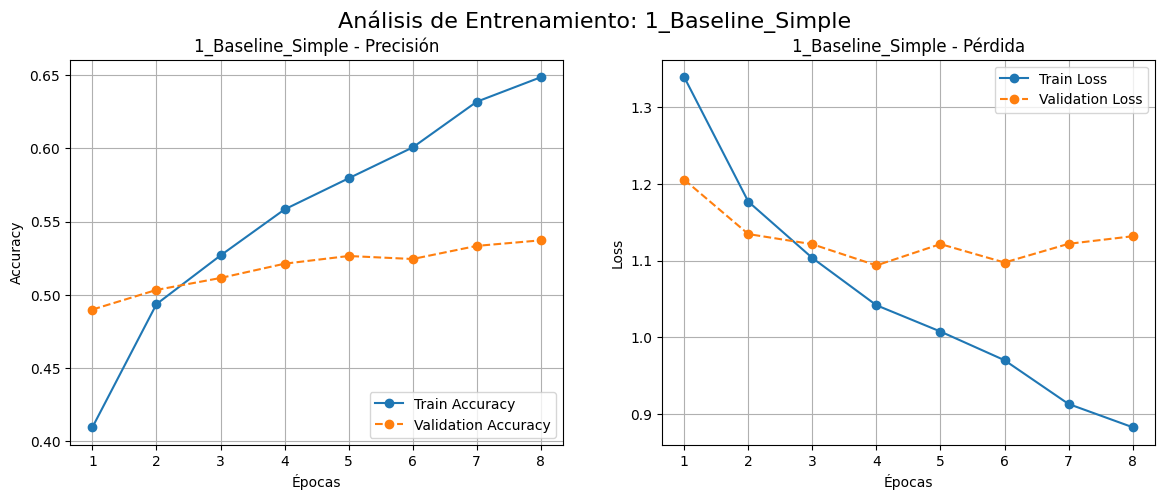

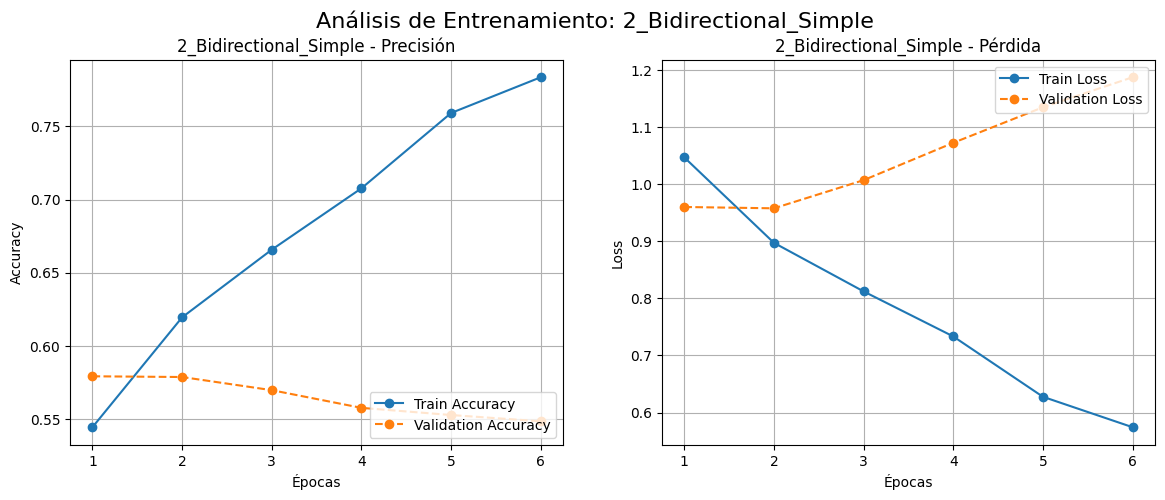

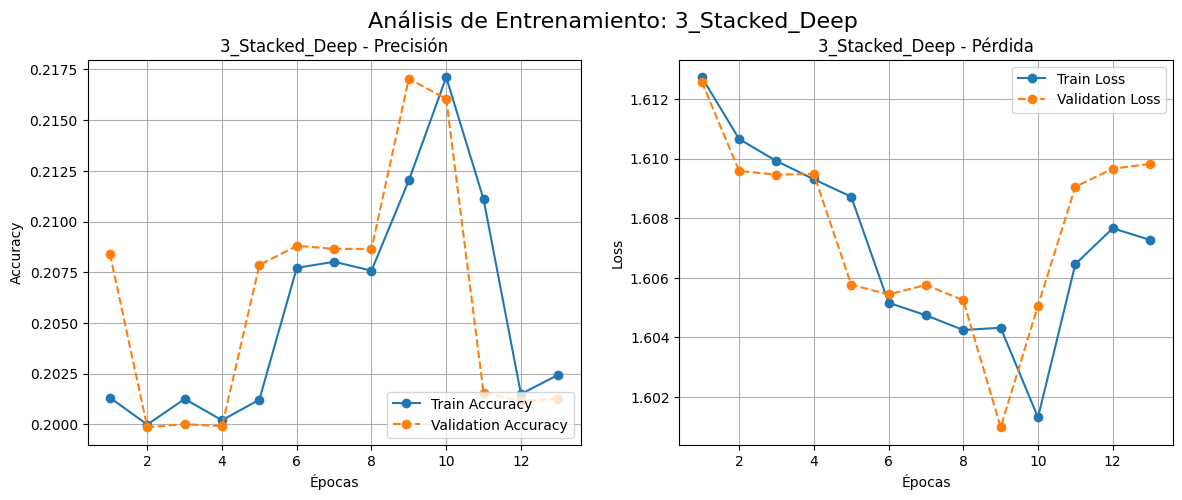

In [7]:
# --- 5. VISUALIZACIÓN DE RESULTADOS DE ENTRENAMIENTO ---
def plot_comprehensive_history(histories):
    for model_name, history in histories.items():
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(1, len(acc) + 1)

        plt.figure(figsize=(14, 5))
        
        # --- Gráfica 1: Precisión (Accuracy) ---
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o', linestyle='--')
        plt.title(f'{model_name} - Precisión')
        plt.xlabel('Épocas')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True)

        # --- Gráfica 2: Pérdida (Loss) ---
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Train Loss', marker='o')
        plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', linestyle='--')
        plt.title(f'{model_name} - Pérdida')
        plt.xlabel('Épocas')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        plt.grid(True)

        plt.suptitle(f"Análisis de Entrenamiento: {model_name}", fontsize=16)
        plt.show()

# Ejecutar visualización
plot_comprehensive_history(historias)

In [8]:
# --- 6. EVALUACIÓN FINAL EN TEST SET DESCONOCIDO ---
print("\n📊 RESULTADOS FINALES (Evaluados en Test Set desconocido):")
print("-" * 60)
results_table = []

for model in modelos:
    # Evaluamos en X_test, que el modelo NUNCA ha visto
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    results_table.append({'Modelo': model.name, 'Test Accuracy': f"{accuracy:.4f}", 'Test Loss': f"{loss:.4f}"})

# Mostrar tabla con Pandas
print(pd.DataFrame(results_table))


📊 RESULTADOS FINALES (Evaluados en Test Set desconocido):
------------------------------------------------------------
                   Modelo Test Accuracy Test Loss
0       1_Baseline_Simple        0.5225    1.1029
1  2_Bidirectional_Simple        0.5796    0.9710
2          3_Stacked_Deep        0.2181    1.5995
